In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from learning_wavelets.data.datasets import im_dataset_bsd68
from learning_wavelets.image_utils import trim_padding
from learning_wavelets.keras_utils.load_model import unpack_model
from learning_wavelets.models.learnlet_model import Learnlet
from learning_wavelets.models.unet import unet

In [3]:
im_shape = (64, 64)
plt.rcParams['figure.figsize'] = tuple(x//8 for x in im_shape)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
tf.random.set_seed(0)

In [5]:
def build_learnlet_subclassing(**run_params):
    model = Learnlet(**run_params)
    model.build([[None, None, None, 1], [None, 1]])
    return model

In [6]:
all_net_params = [
    {
        'name': 'unet_0_55',
        'init_function': unet,
        'run_params': {
            'n_layers': 5, 
            'pool': 'max', 
            "layers_n_channels": [64, 128, 256, 512, 1024], 
            'layers_n_non_lins': 2,
            'non_relu_contract': False,
            'bn': True,
            'input_size': (None, None, 1),
        },
        'run_id': 'unet_dynamic_st_bsd500_0_55_1576668365',
        'epoch': 500,
    },
]

dynamic_denoising_net_params = [
{
        'name': 'learnlet',
        'init_function': build_learnlet_subclassing,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 64, 
                'mixing_details': False,    
                'skip_connection': True,
                'kernel_size': 11,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'threshold_kwargs':{
                'noise_std_norm': True,
            },
            'n_scales': 5,
            'exact_reconstruction': True,
            'n_reweights_learn': 1,
            'undecimated': True,
            'clip': False,
        },
        'run_id': 'learnlet_subclassed_undecimated_exact_reco_64_dynamic_soft_thresholding_bsd500_0.0_55.0_None_1582907244',
        'epoch': 100,
    },
]

In [7]:
noise_std = [1.]
dirac = np.zeros(im_shape, dtype=np.float32)
dirac[im_shape[0]//2, im_shape[1]//2] = 255
im_gt = tf.convert_to_tensor(dirac)[None, ..., None]
tf_noise_std = tf.convert_to_tensor(noise_std)
noise = tf.random.normal(im_shape, stddev=tf_noise_std)[None, ..., None]
print(tf.reduce_sum(noise))
im_noisy = im_gt + noise
im_noisy = (im_noisy / 255) - 0.5
im_gt = (im_gt / 255) - 0.5
tf_noise_std = tf_noise_std[None, ...] / 255

tf.Tensor(40.95352, shape=(), dtype=float32)


In [8]:
unet_model = unpack_model(**all_net_params[0])
im_denoised_unet = unet_model(im_noisy)
learnlet_model = unpack_model(**dynamic_denoising_net_params[0])
im_denoised_learnlet = learnlet_model([im_noisy, tf_noise_std])

In [9]:
images_to_plot = {
#     'original': im_gt,
#     'noisy': im_noisy,
    'unet': im_denoised_unet,
    'learnlets': im_denoised_learnlet,
}

In [14]:
tf.reduce_max(im_denoised_unet - im_gt)

<tf.Tensor: shape=(), dtype=float32, numpy=0.03762266>

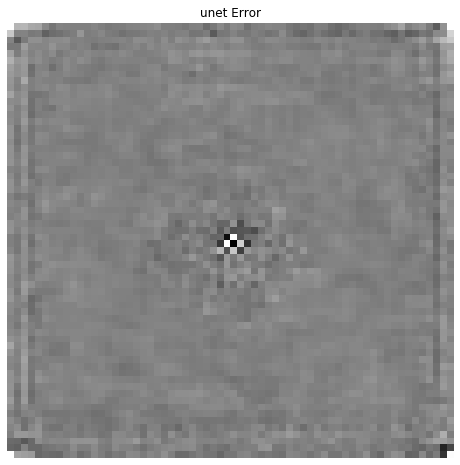

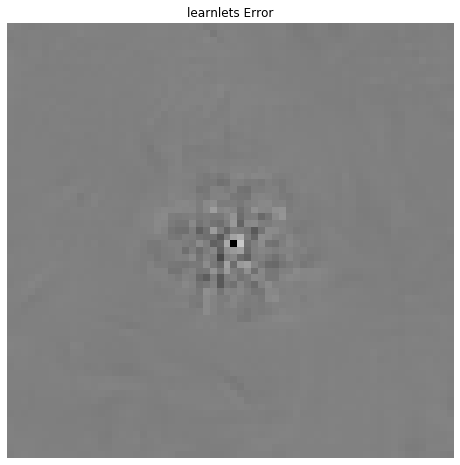

In [16]:
for name, im in images_to_plot.items():
    plt.figure()
    im_squeezed = (np.squeeze((im - im_gt).numpy())) * 255
    plt.imshow(im_squeezed, vmax=0.03 * 255, vmin=-0.03 * 255, aspect='auto')
    plt.axis('off')
    plt.title(f'{name} Error')
    plt.savefig(f'denoising_dirac_{name}_error.png', bbox_inches='tight')

In [11]:
# for name, im in images_to_plot.items():
#     plt.figure()
#     im_squeezed = (np.squeeze(im.numpy()) + 0.5) * 255
#     plt.imshow(im_squeezed, vmin=0, vmax=255, aspect='auto')
#     plt.axis('off')
#     plt.title(f'{name}, with max  {np.max(im_squeezed)}, and sum {np.sum(im_squeezed)}')
#     plt.savefig(f'denoising_dirac_{name}.png', bbox_inches='tight')